## First, install the necessary libraries:

In [1]:
!pip install opencv-python face_recognition numpy pandas matplotlib seaborn scikit-learn

## Setup Environment

In [7]:
# Import necessary libraries
import cv2
import face_recognition
import numpy as np
import pandas as pd
import datetime
import os
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Set up directories for images and data
if not os.path.exists('employee_faces'):
    os.makedirs('employee_faces')

if not os.path.exists('attendance_logs'):
    os.makedirs('attendance_logs')


## Register Employees

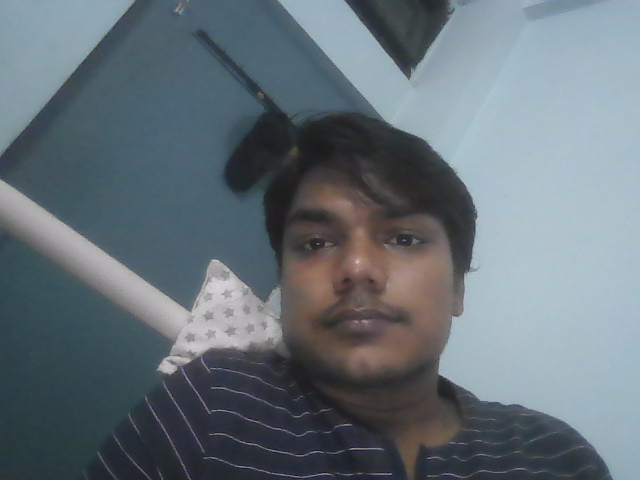

Image saved at employee_faces/101_Rahul.jpg


In [8]:
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import os
import time

def register_employee():
    # Get employee details from input
    employee_id = input("Enter Employee ID: ")
    employee_name = input("Enter Employee Name: ")
    
    # Create the directory to save employee images if it doesn't exist
    if not os.path.exists('employee_faces'):
        os.makedirs('employee_faces')
    
    # Open the webcam
    video_capture = cv2.VideoCapture(0)  # 0 is usually the default webcam
    
    if not video_capture.isOpened():
        print("Error: Could not open webcam.")
        return
    
    print(f"Capturing face for {employee_name} (ID: {employee_id})... Image will be saved in 5 seconds.")
    
    start_time = time.time()  # Record the start time
    
    while True:
        # Capture frame-by-frame
        ret, frame = video_capture.read()
        
        if not ret:
            print("Failed to capture image.")
            break
        
        # Convert the frame to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert the frame to a PIL image for display in Jupyter Notebook
        img_pil = Image.fromarray(frame_rgb)
        
        # Display the frame in the notebook
        clear_output(wait=True)  # Clear previous frames
        display(img_pil)  # Display current frame
        
        # Check if 5 seconds have passed
        if time.time() - start_time > 5:
            # Save the current frame as the employee's image
            image_path = f"employee_faces/{employee_id}_{employee_name}.jpg"
            cv2.imwrite(image_path, frame)  # Save the image in the 'employee_faces' directory
            print(f"Image saved at {image_path}")
            break
    
    # Release the webcam
    video_capture.release()

# Call the function to start registration
register_employee()


## Facial Recognition for Check-In/Check-Out & Spoof

In [10]:
import cv2
import face_recognition
import numpy as np
import os
import pandas as pd
from datetime import datetime, timedelta
import time

# Initialize video capture (0 for the default camera)
video_capture = cv2.VideoCapture(0)

# Load known faces and their names
known_faces = []
known_names = []
attendance_log = {}  # Dictionary to track check-in and check-out status

# Load your known faces and names from your dataset
def load_known_faces(known_faces_directory):
    for filename in os.listdir(known_faces_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image = face_recognition.load_image_file(os.path.join(known_faces_directory, filename))
            face_encoding = face_recognition.face_encodings(image)[0]
            known_faces.append(face_encoding)
            known_names.append(os.path.splitext(filename)[0])  # Use the filename as the name

load_known_faces('employee_faces')  # Update the path

# Function to log attendance to CSV (in the same row)
def log_attendance(employee_id, name, status):
    try:
        # Read the existing attendance log
        df = pd.read_csv("attendance.csv")
    except FileNotFoundError:
        # If file doesn't exist, create a new DataFrame with the required columns
        df = pd.DataFrame(columns=["ID", "Employee Name", "Date", "Time", "Status"])

    # Log the attendance entry
    now = datetime.now()
    date_str = now.strftime('%Y-%m-%d')
    time_str = now.strftime('%H:%M:%S')
    new_row = {
        "ID": employee_id,
        "Employee Name": name,
        "Date": date_str,
        "Time": time_str,
        "Status": status
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)  # Use pd.concat instead of append
    df.to_csv("attendance.csv", index=False)  # Save the updated DataFrame back to the CSV

# Function to check for spoofing using Haar Cascade
def is_spoof(frame):
    # Load Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
    
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

    # If faces are detected, return False (not a spoof)
    if len(faces) > 0:
        return False

    # If no faces are detected, it's likely a spoof
    return True

# Function to handle check-in and check-out process
def check_in_check_out():
    while True:
        ret, frame = video_capture.read()
        if not ret:
            print("Failed to capture frame. Exiting...")
            break

        # Convert the image from BGR to RGB and resize for faster processing
        rgb_small_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb_small_frame = cv2.resize(rgb_small_frame, (0, 0), fx=0.25, fy=0.25)

        # Find all face locations and encodings
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        for face_encoding, face_location in zip(face_encodings, face_locations):
            matches = face_recognition.compare_faces(known_faces, face_encoding)
            name = "Unknown"
            if True in matches:
                first_match_index = matches.index(True)
                name = known_names[first_match_index]
                employee_id = name.split('_')[0]  # Extracting employee ID from name format

                print(f"Recognized: {name} (ID: {employee_id})")
                now = datetime.now()

                # Check for spoofing
                if is_spoof(frame):
                    print(f"Access denied for {name}! Spoof detected.")
                    log_attendance(employee_id, name, status="Access Denied")
                    continue

                # Check if employee has already checked in
                if employee_id not in attendance_log:
                    # First time seeing the face today - log check-in
                    print(f"Checking in {name} (ID: {employee_id}). Please wait...")
                    time.sleep(np.random.randint(3, 9))  # Wait for 3 to 8 seconds for recognition
                    log_attendance(employee_id, name, status="Check-in")
                    attendance_log[employee_id] = {"check_in": now, "check_out": None}
                    print(f"{name} (ID: {employee_id}) checked in at {now.strftime('%H:%M:%S')}")

                elif employee_id in attendance_log:
                    check_in_time = attendance_log[employee_id]["check_in"]
                    check_out_time = attendance_log[employee_id]["check_out"]

                    # If already checked in, check-out process
                    if check_out_time is None:
                        if now - check_in_time >= timedelta(minutes=5):  # Must wait 5 min after check-in
                            print(f"Checking out {name} (ID: {employee_id}). Please wait...")
                            time.sleep(np.random.randint(3, 9))  # Wait for 3 to 8 seconds for recognition
                            log_attendance(employee_id, name, status="Check-out")
                            attendance_log[employee_id]["check_out"] = now
                            print(f"{name} (ID: {employee_id}) checked out at {now.strftime('%H:%M:%S')}")

                        else:
                            print(f"{name} (ID: {employee_id}) must wait before checking out.")
                    else:
                        # Already checked out - allow check-in after 5 min cooldown
                        if now - check_out_time >= timedelta(minutes=5):
                            print(f"Checking in {name} (ID: {employee_id}). Please wait...")
                            time.sleep(np.random.randint(3, 9))  # Wait for 3 to 8 seconds for recognition
                            log_attendance(employee_id, name, status="Check-in")
                            attendance_log[employee_id]["check_in"] = now
                            attendance_log[employee_id]["check_out"] = None  # Reset check-out status
                            print(f"{name} (ID: {employee_id}) checked in at {now.strftime('%H:%M:%S')}")
                        else:
                            print(f"{name} (ID: {employee_id}) must wait before checking in again.")

            # Draw a rectangle around the face
            top, right, bottom, left = [v * 4 for v in face_location]
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(frame, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

        # Display the video feed with the recognized names
        cv2.imshow('Video', frame)

        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release video capture and close windows
    video_capture.release()
    cv2.destroyAllWindows()

# Start the check-in/check-out system
check_in_check_out()


Recognized: 101_Rahul (ID: 101)
Checking in 101_Rahul (ID: 101). Please wait...
101_Rahul (ID: 101) checked in at 23:08:01
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
Access denied for 101_Rahul! Spoof detected.
Recognized: 101_Rahul (ID: 101)
Access denied for 101_Rahul! Spoof detected.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wait before checking out.
Recognized: 101_Rahul (ID: 101)
101_Rahul (ID: 101) must wa

## Attendance log

In [11]:
import pandas as pd
import os
from datetime import datetime

# Function to generate attendance report for a specific date
def generate_daily_attendance_report():
    # Read the attendance CSV file
    try:
        df = pd.read_csv("attendance.csv")
    except FileNotFoundError:
        print("Attendance CSV file not found.")
        return
    
    # Convert the 'Date' column to datetime for easier manipulation
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Get the unique dates from the CSV file
    unique_dates = df['Date'].dt.date.unique()
    
    # Iterate over each unique date
    for date in unique_dates:
        # Filter the data for that specific date
        daily_data = df[df['Date'].dt.date == date]
        
        # Get the list of unique employees for that date
        employees = daily_data['Employee Name'].unique()

        # Create a dictionary to store attendance status
        attendance_status = {}

        # Loop over each employee
        for employee in employees:
            employee_data = daily_data[daily_data['Employee Name'] == employee]
            
            # Check if there is both check-in and check-out for that employee
            check_in_exists = any(employee_data['Status'] == 'Check-in')
            check_out_exists = any(employee_data['Status'] == 'Check-out')
            
            # If both check-in and check-out exist, mark as 'Present', else 'Absent'
            if check_in_exists and check_out_exists:
                attendance_status[employee] = 'Present'
            else:
                attendance_status[employee] = 'Absent'

        # Create a DataFrame from the attendance status
        attendance_report_df = pd.DataFrame(list(attendance_status.items()), columns=['Employee Name', 'Status'])

        # Save the report to a new CSV file in 'attendance_logs' folder
        folder_path = 'attendance_logs'
        os.makedirs(folder_path, exist_ok=True)  # Ensure the folder exists
        report_file_path = os.path.join(folder_path, f"{date}_attendance.csv")
        attendance_report_df.to_csv(report_file_path, index=False)

        print(f"Attendance report generated for {date}: {report_file_path}")

# Run the function to generate daily attendance reports
generate_daily_attendance_report()


Attendance report generated for 2024-10-21: attendance_logs\2024-10-21_attendance.csv


## Generate Attendance Reports

In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime

# Function to calculate work hours from check-in and check-out times
def calculate_work_hours(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

    # Create an empty list to store work hours data
    work_hours_list = []

    # Group data by Employee Name and Date
    for name, group in df.groupby(['Employee Name', 'Date']):
        check_in_times = group[group['Status'] == 'Check-in']['Time']
        check_out_times = group[group['Status'] == 'Check-out']['Time']

        # Calculate total work hours (only if both check-in and check-out exist)
        if not check_in_times.empty and not check_out_times.empty:
            check_in = datetime.combine(group['Date'].iloc[0], check_in_times.iloc[0])
            check_out = datetime.combine(group['Date'].iloc[0], check_out_times.iloc[0])
            work_duration = round((check_out - check_in).total_seconds() / 3600, 2)  # Convert seconds to hours and round to 2 decimals
            work_hours_list.append({'Employee Name': name[0], 'Date': name[1], 'Work Hours': work_duration})

    # Convert list to DataFrame
    work_hours_df = pd.DataFrame(work_hours_list)
    return work_hours_df

# Function to generate daily, weekly, and monthly reports
def generate_attendance_reports(work_hours_df):
    folder_path = 'Attendance_reports'
    os.makedirs(folder_path, exist_ok=True)

    # Generate daily report
    daily_report = work_hours_df.groupby(['Employee Name', 'Date'])['Work Hours'].sum().reset_index()
    daily_report.to_csv(os.path.join(folder_path, 'daily_report.csv'), index=False)
    print("Daily report generated.")

    # Generate weekly report
    work_hours_df['Week'] = work_hours_df['Date'].dt.strftime('%Y-%U')  # %U is the week number
    weekly_report = work_hours_df.groupby(['Employee Name', 'Week'])['Work Hours'].sum().reset_index()
    weekly_report.to_csv(os.path.join(folder_path, 'weekly_report.csv'), index=False)
    print("Weekly report generated.")

    # Generate monthly report
    work_hours_df['Month'] = work_hours_df['Date'].dt.strftime('%Y-%m')
    monthly_report = work_hours_df.groupby(['Employee Name', 'Month'])['Work Hours'].sum().reset_index()
    monthly_report.to_csv(os.path.join(folder_path, 'monthly_report.csv'), index=False)
    print("Monthly report generated.")

# Function to generate bar graphs for daily, weekly, and monthly work hours
def generate_attendance_graphs(work_hours_df):
    graph_folder_path = os.path.join('Attendance_reports', 'graph_reports')
    os.makedirs(graph_folder_path, exist_ok=True)

    # Daily bar graph
    daily_report = work_hours_df.groupby(['Employee Name', 'Date'])['Work Hours'].sum().reset_index()
    plt.figure(figsize=(10, 6))
    for name in daily_report['Employee Name'].unique():
        employee_data = daily_report[daily_report['Employee Name'] == name]
        plt.bar(employee_data['Date'].astype(str), employee_data['Work Hours'], label=name)  # Bar chart
    plt.title('Daily Work Hours')
    plt.xlabel('Date')
    plt.ylabel('Work Hours')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(graph_folder_path, 'daily_work_hours.png'))
    plt.close()
    print("Daily work hours bar graph generated.")

    # Weekly bar graph
    weekly_report = work_hours_df.groupby(['Employee Name', 'Week'])['Work Hours'].sum().reset_index()
    plt.figure(figsize=(10, 6))
    for name in weekly_report['Employee Name'].unique():
        employee_data = weekly_report[weekly_report['Employee Name'] == name]
        plt.bar(employee_data['Week'], employee_data['Work Hours'], label=name)  # Bar chart
    plt.title('Weekly Work Hours')
    plt.xlabel('Week')
    plt.ylabel('Work Hours')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(graph_folder_path, 'weekly_work_hours.png'))
    plt.close()
    print("Weekly work hours bar graph generated.")

    # Monthly bar graph
    monthly_report = work_hours_df.groupby(['Employee Name', 'Month'])['Work Hours'].sum().reset_index()
    plt.figure(figsize=(10, 6))
    for name in monthly_report['Employee Name'].unique():
        employee_data = monthly_report[monthly_report['Employee Name'] == name]
        plt.bar(employee_data['Month'], employee_data['Work Hours'], label=name)  # Bar chart
    plt.title('Monthly Work Hours')
    plt.xlabel('Month')
    plt.ylabel('Work Hours')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(graph_folder_path, 'monthly_work_hours.png'))
    plt.close()
    print("Monthly work hours bar graph generated.")

# Load the attendance CSV file
def main():
    try:
        attendance_df = pd.read_csv("attendance.csv")
    except FileNotFoundError:
        print("attendance.csv not found.")
        return

    # Calculate work hours
    work_hours_df = calculate_work_hours(attendance_df)

    # Generate reports
    generate_attendance_reports(work_hours_df)

    # Generate bar graphs
    generate_attendance_graphs(work_hours_df)

# Run the main function
if __name__ == "__main__":
    main()


Daily report generated.
Weekly report generated.
Monthly report generated.
Daily work hours bar graph generated.
Weekly work hours bar graph generated.
Monthly work hours bar graph generated.


## Deployment